# Grid Intersection comparison

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import geopandas as gpd
import flopy
import flopy.discretization as fgrid
from flopy.utils.gridintersect import GridIntersect
import rtree
import shapely
from shapely.geometry import Polygon   

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('shapely version: {}'.format(shapely.__version__))
print('geopandas version: {}'.format(gpd.__version__))

/home/david/anaconda3/envs/artesia/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
numpy version: 1.21.2
flopy version: 3.3.6
shapely version: 1.8.2
geopandas version: 0.10.1


In [2]:
import shapely.geos
shapely.geos.geos_version_string
# from shapely import speedups
# speedups.enabled

'3.10.2-CAPI-1.16.0'

In [2]:
def get_structured_grid(nrnc):
    delc = 1000/nrnc * np.ones(nrnc, dtype=float)
    delr = 1000/nrnc * np.ones(nrnc, dtype=float)
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None)
    return sgr

## GridIntersect

In [3]:
# set intersection method
method = "vertex"
rtree_bool = True

#get grid and build rtree
nrnc = 500
sgr = get_structured_grid(nrnc)
t = %timeit -o -r 1 -n 1 GridIntersect(sgr, method="vertex", rtree=rtree_bool)
print("Building Tree", "{0}x{0}".format(nrnc) + f": {t.average:.2f} seconds")

/home/david/Github/flopy/flopy/utils/gridintersect.py:276: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)


5.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Building Tree 500x500: 5.16 seconds


In [4]:
# create GridIntersect object again for intersection calls
ix = GridIntersect(sgr, method=method, rtree=rtree)

# create some polygon to intersect with grid
shp = Polygon([(1, 1), (999, 999), (750, 1000), (2, 250), (1, 1)])

# test looping over multiple shapes
# N = 1 # no of intersection calls
# results = [] # store results
# for i in tqdm(range(N)):
#     results.append(ix.intersect(shp))
    
t = %timeit -o -r 1 -n 1 ix.intersect(shp)
print(f"GridIntersect.intersect() (method='vertex', rtree=True): {t.average:.2f} seconds")

t = %timeit -o -r 1 -n 1 ix.intersects(shp)
print(f"GridIntersect.intersects() (method='vertex', rtree=True): {t.average:.2f} seconds")

8.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
GridIntersect.intersect() (method='vertex', rtree=True): 8.35 seconds
1.83 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
GridIntersect.intersects() (method='vertex', rtree=True): 1.83 seconds


<AxesSubplot:>

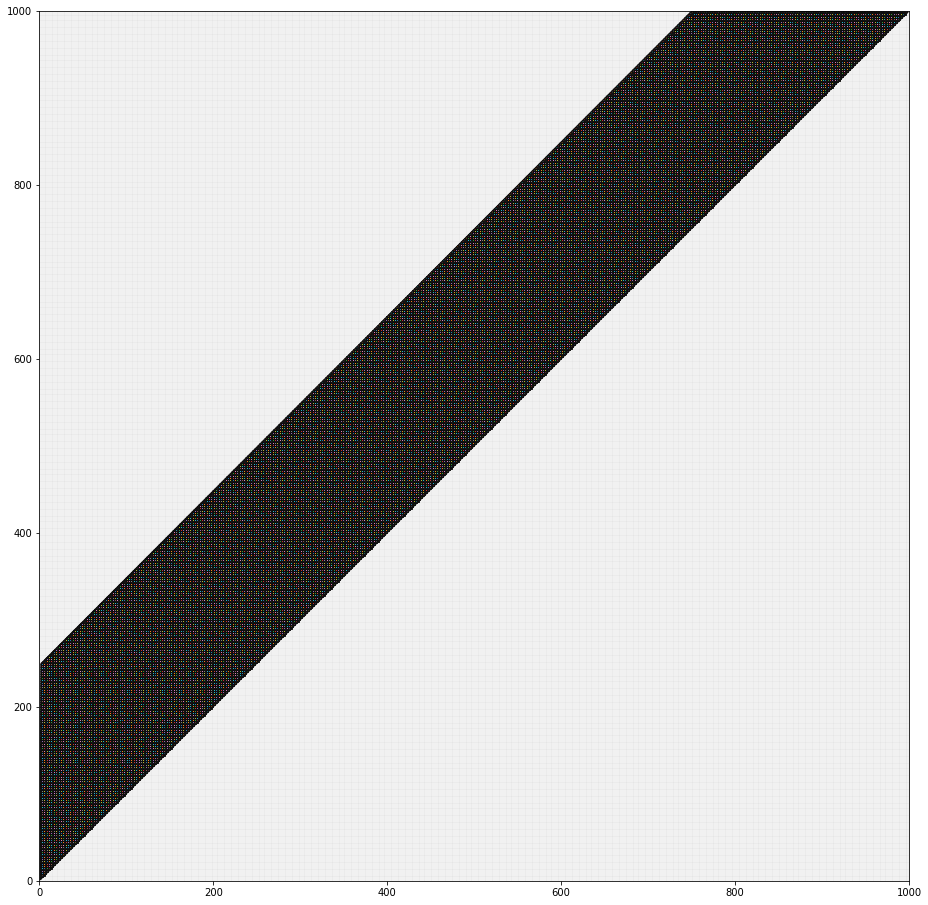

In [5]:
# plot intersect result (this can take a while)
r = ix.intersect(shp)
fig, ax =plt.subplots(1, 1, figsize=(16, 16))
sgr.plot(ax=ax, lw=0.1)
ix.plot_polygon(r, ax=ax);

## geopandas
I'm not using the latest version of geopandas (I don't think), so that might change the timing some. Also i do not have `pygeos` installed which I think can make geopandas geo-operations faster. 
For me this is a lot slower than GridIntersect.

In [6]:
griddf = gpd.GeoDataFrame(geometry=ix._rect_grid_to_shape_list())  # create grid geodataframe
shapes = gpd.GeoDataFrame(geometry=[shp]*1)  # create shapes geodataframe

t = %timeit -o -r 1 -n 1 gpd.sjoin(griddf, shapes, how="left")
print(f"geopandas sjoin (grid, shapes): {t.average:.2f} seconds")

t = %timeit -o -r 1 -n 1 gpd.sjoin(shapes, griddf, how="left")
print(f"geopandas sjoin (shapes, grid): {t.average:.2f} seconds")

24.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
geopandas sjoin: 24.68 seconds
18.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
geopandas sjoin: 18.67 seconds


## rtree

Building the tree takes a lot longer than GridIntersect, 50 seconds vs 4 seconds.

In [7]:
# rtree index - takes a little while
idx = rtree.index.Index()
for i, g in tqdm(enumerate(ix._rect_grid_to_shape_list()), total=sgr.nrow * sgr.ncol):
    idx.insert(i, g.bounds)

100%|██████████| 250000/250000 [00:52<00:00, 4748.90it/s]


This gets you the same result as GridIntersect.intersects() if I'm not mistaken? So only the index of intersected cells and not the actual resulting intersection shapes.

In [8]:
%%timeit -r 1 -n 1
intersected = []
for pind, poly in tqdm(enumerate(shapes['geometry'].values)):
    inds = [i for i in idx.intersection(poly.bounds)]
    inds = [i for i in inds if griddf.geometry.iloc[i].intersects(poly)]
    intersected.append(inds)

1it [00:05,  5.40s/it]
1it [00:05,  5.71s/it]
1it [00:05,  5.72s/it]
1it [00:05,  5.83s/it]
1it [00:05,  5.51s/it]
1it [00:05,  5.44s/it]
1it [00:05,  5.47s/it]
1it [00:05,  5.36s/it]

5.58 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Summarizing:

|Method|Timing|
| :- | :- |
|GridIntersect (build tree)| 4s |
|GridIntersect (intersect)| 8.3s |
|GridIntersect (intersects)| 1.8s |
|Geopandas (sjoin)| ~20s |
|rtree (build tree) | 52s |
|rtree (intersects) | 5.6s |